# My implementation of Actor-Critic Method

In this file, I will use the Panda-Robotics to evaluate my agent's perfermance

## import some packages and check the env

*Remerber:* we need to install panda_gym

*pip install panda_gym*

In [1]:
import gymnasium as gym
import numpy as np
# these are new packages in this file
import panda_gym
import stable_baselines3
from stable_baselines3.common.vec_env import DummyVecEnv, VecNormalize
from stable_baselines3.common.env_util import make_vec_env
from collections import deque
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
env_id = 'PandaReachDense-v3'
env = gym.make(env_id)
state_space = env.observation_space
action_space = env.action_space.shape
print(f'state space: {state_space}')
print(f'action space: {action_space}')

pybullet build time: Oct  5 2023 20:55:18


argv[0]=--background_color_red=0.8745098114013672
argv[1]=--background_color_green=0.21176470816135406
argv[2]=--background_color_blue=0.1764705926179886
state space: Dict('achieved_goal': Box(-10.0, 10.0, (3,), float32), 'desired_goal': Box(-10.0, 10.0, (3,), float32), 'observation': Box(-10.0, 10.0, (6,), float32))
action space: (3,)


In [3]:
env = make_vec_env(env_id, n_envs=1)

env = VecNormalize(env, norm_obs=True, norm_reward=True, clip_obs=10.)

obs = env.reset()

achieved_goal = obs['achieved_goal']
desired_goal = obs['desired_goal']
observation = obs['observation']

merged_array = np.concatenate([achieved_goal, desired_goal, observation], axis=-1)
merged_array.shape

argv[0]=--background_color_red=0.8745098114013672
argv[1]=--background_color_green=0.21176470816135406
argv[2]=--background_color_blue=0.1764705926179886


(1, 12)

In [4]:
action  = env.action_space.sample()
env.step(action)

(OrderedDict([('achieved_goal',
               array([[-0.6105237 , -0.72835785, -0.7316284 ]], dtype=float32)),
              ('desired_goal',
               array([[-0.00088541, -0.00065981,  0.00091386]], dtype=float32)),
              ('observation',
               array([[-0.6105237 , -0.72835785, -0.7316284 , -0.99650955, -0.9983161 ,
                       -0.9974355 ]], dtype=float32))]),
 array([-10.], dtype=float32),
 array([False]),
 [{'is_success': False, 'TimeLimit.truncated': False}])

## Build compentes of the A2C algorithm

1. Actor Network

2. Value-function Network

There are serval common baseline

1. REINFORCE

2. Q Actor-Critic

3. Advantage Actor-Critic

4. TD Actor-Critic

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
# we don't use the Categorical since the actions are continuous
# we should use the Normal to model the continous distribution
from torch.distributions import Categorical,Normal

In [6]:
# # we conbine the actornetwork and criticnetwork into a whole network
# class ActorCritic(nn.Module):
#     """This network includes a net to output action and a net to output value"""
#     def __init__(
#         self,
#         state_space,
#         action_space,
#         lr,
#         device,
#         fc1_unit = 64,
#         fc2_unit = 64
#     ):
#         super(ActorCritic,self).__init__()
#         self.state_space = state_space
#         self.action_space = action_space
#         self.lr = lr
#         self.device = device
        
#         # nn.Sequential is really helpful
#         # Actor
#         self.actor = nn.Sequential(
#             nn.Linear(state_space,fc1_unit),
#             # in the sequential we should use the nn.ReLU() instead of torch.nn.functional.relu()
#             # cause nn.ReLU is a module while functional.relu is a independent function
#             nn.ReLU(),
#             nn.Linear(fc1_unit,fc2_unit),
#             nn.ReLU(),
#             # action_space * 2: we aim to output the mean and std of the action distribution
#             nn.Linear(fc2_unit,action_space*2)
#         )
        
#         # Critic
#         self.critic = nn.Sequential(
#             nn.Linear(state_space,fc1_unit),
#             nn.ReLU(),
#             nn.Linear(fc1_unit,fc2_unit),
#             nn.ReLU(),
#             nn.Linear(fc2_unit,1) # output the value
#         )
        
#         self.optimizer = optim.Adam(self.parameters(),lr = lr)
#         self.to(self.device)
        
#     def forward(self,state):

#         value = self.critic(state)
        
#         # output the mean and std of action distribution
#         x = self.actor(state)
#         # why log_std?
#         # because the log_std is (-infinite, +infinite)
#         mean,log_std = x[:,:self.action_space], x[:,self.action_space:]
#         return value,mean,log_std
    
#     def process_input(self,x):
#         achieved_goal = x['achieved_goal']
#         desired_goal = x['desired_goal']
#         observation = x['observation']
#         merged_array = np.concatenate([achieved_goal, desired_goal, observation], axis=-1)
#         state = torch.from_numpy(merged_array).float()
#         return state

In [7]:
# helper function: to concatenate the input and convert them to tensor
def t(x):
    achieved_goal = x['achieved_goal']
    desired_goal = x['desired_goal']
    observation = x['observation']
    merged_array = np.concatenate([achieved_goal, desired_goal, observation], axis=-1)
    return torch.from_numpy(merged_array).float()

In [8]:
# I found that the results are bad and the agent can't learn anything easily, so I decide to split one network to two networks
# which are updated sperately
# Actor module, categorical actions only
class Actor(nn.Module):
    def __init__(self, state_space, action_space,lr,device):
        super(Actor,self).__init__()
        self.model = nn.Sequential(
            nn.Linear(state_space, 64),
            nn.Tanh(),
            nn.Linear(64, 32),
            nn.Tanh(),
            nn.Linear(32, action_space * 2), #the acition space is continous
        )
        self.optimizer = optim.Adam(self.parameters(),lr=lr)
        self.to(device)
    
    def forward(self, X):
        return self.model(t(X))

In [9]:
# Critic module
class Critic(nn.Module):
    def __init__(self, state_space,lr,device):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(state_space, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 1)
        )
        self.optimizer = optim.Adam(self.parameters(),lr=lr)
        self.to(device)
    
    def forward(self, X):
        return self.model(t(X))

## build an agent and play the game

![algorithm_figure](/Users/gaohaitao/robotics-tutorial/Algotithms/A2C.png)

*This picture is from https://towardsdatascience.com/understanding-actor-critic-methods-931b97b6df3f*

In [10]:
class Agent():
    def __init__(
        self,
        env: gym.envs,
        state_space: int,
        action_space: int,
        lr: float,
        device: torch.device,
        gamma: float, # discounted rewards
        n_training_episodes: int,
        max_t: int
    ):
        # init the variables
        self.env = env
        self.state_space = state_space
        self.action_space = action_space
        self.lr = lr
        self.device = device
        self.gamma = gamma
        self.n_training_episodes = n_training_episodes
        self.max_t = max_t
        
        # self.actor_critic = ActorCritic(state_space,action_space,
        #                                 lr,device)
        self.actor = Actor(state_space,action_space,lr,device)
        self.critic = Critic(state_space,lr,device)
        
    def act(self,state):
        # choose an action given a state
        ## Firstly, we should convert the state to torch.tensor since we need use GPU to train
        ## This is new to the code because the input state is a Dict
        ## The dict includes 'observation', 'achieved_goal', 'desired_goal'
        # the operation of sampling action is different with previous codes
        # we need use the Normal() to model the distribution using mean and log_std
        # then, sample the action
        act_out = self.actor(state)
        mean = act_out[:,:self.action_space]
        log_std = act_out[:,self.action_space:]
        # convert log_std to std
        std = torch.exp(log_std)
        normal = Normal(mean,std)
        action = normal.sample()
        log_prob = normal.log_prob(action)
        return action.numpy(),log_prob
    
    def step(self,action):
        # the agent take the action and obtain the next observation and immedient reward
        next_obs,reward,done,info = self.env.step(action)
        return next_obs, reward, done
    
    def update(self,advantage,log_prob):
        """this is different with previous codes because we need to update two networks at each time_step"""
        # Note that Variable 'advantages' must be tensor
        # policy_loss = -torch.mean(advantage * log_prob)
        # loss_array = -advantage.detach() * log_prob
        # loss = torch.mean(loss_array)
        policy_loss = torch.mean(-advantage.detach() * log_prob)
        self.actor.optimizer.zero_grad()
        policy_loss.backward()
        self.actor.optimizer.step()
        
        
        critic_loss = advantage.pow(2).mean()
        self.critic.optimizer.zero_grad()
        critic_loss.backward()
        self.critic.optimizer.step()
        
    def train(self):
        """the agent will play many episodes and update it's parameters"""
        scores_deque = deque(maxlen=100)
        scores = []
        avg_scores = []
        
        for episode in range(self.n_training_episodes):
            # init some lists to store the infos
            rewards = []
            # in this method, we don't need to init saved_log_probs and rewards
            # since we update the network at each timestep
            # only need the immedient reward and predition of value
            
            # init the env where there isn't info
            state = self.env.reset()
            
            # loop max_t
            for t in range(self.max_t):
                # sample an action
                action,log_prob = self.act(state)
                # stepforward
                next_obs,reward,done = self.step(action)
                rewards.append(reward)
                # compute the advantage function
                # A = r + gamma * V(next) - V(now)
                value = self.critic(state)
                value_ = self.critic(next_obs)
                advantage = torch.tensor(reward).float() + self.gamma * value_ * (1 - int(done)) - value
                self.update(advantage,log_prob)
                
                if done:
                    break
                
                state = next_obs
            
            scores_deque.append(sum(rewards))
            scores.append(sum(rewards))
            avg_scores.append(np.mean(scores_deque))
            
            if episode % 100 == 0:
                print(f'episode: {episode} | average score: {np.mean(scores_deque)}')
                
        fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
        fig.suptitle('Training Progress')

        ax1.plot(scores, label='Episode Scores', color='b')
        ax1.set_xlabel('Episode')
        ax1.set_ylabel('scores', color='b')
        ax1.tick_params(axis='y', labelcolor='b')

        ax2.plot(avg_scores, label='Episode Average Score', color='r')
        ax2.set_xlabel('Episode')
        ax2.set_ylabel('Average Score', color='r')
        ax2.tick_params(axis='y', labelcolor='r')
        
        

In [11]:
# Hyperparameters
state_space = merged_array.shape[-1]
action_space = env.action_space.shape[0]
lr = 0.001
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
gamma = 0.9
n_training_episodes = 2000
max_t = 10000

RoboticsAgent = Agent(
    env,
    state_space,
    action_space,
    lr,
    device,
    gamma,
    n_training_episodes,
    max_t
)

/var/folders/xt/fs8f0mrx5c7d2_ny5vdyy0ym0000gp/T/ipykernel_23534/3455426554.py:95: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  advantage = torch.tensor(reward).float() + self.gamma * value_ * (1 - int(done)) - value


episode: 0 | average score: -16.281408309936523
episode: 100 | average score: -3.2839624881744385
episode: 200 | average score: -2.8379480838775635
episode: 300 | average score: -2.6558077335357666
episode: 400 | average score: -4.031222343444824
episode: 500 | average score: -4.165024280548096
episode: 600 | average score: -3.6145904064178467
episode: 700 | average score: -3.2773232460021973
episode: 800 | average score: -2.437318801879883
episode: 900 | average score: -2.296854019165039
episode: 1000 | average score: -2.2889769077301025
episode: 1100 | average score: -1.7417058944702148
episode: 1200 | average score: -1.7187095880508423
episode: 1300 | average score: -1.9060144424438477
episode: 1400 | average score: -2.9497971534729004
episode: 1500 | average score: -3.6114282608032227
episode: 1600 | average score: -3.6955323219299316
episode: 1700 | average score: -3.6326990127563477
episode: 1800 | average score: -3.1411712169647217
episode: 1900 | average score: -2.9175422191619

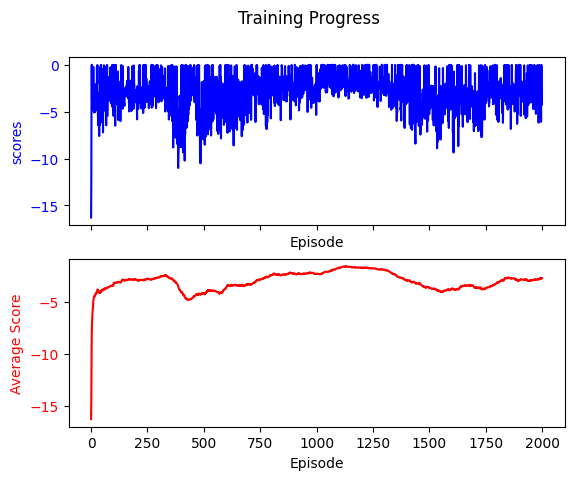

In [12]:
RoboticsAgent.train()

According to the training progress figure, the dense reward are every close to zero that is a great result since the reward is the negtive
Euclidean distance between the achieved goal position and the desired goal position.

Don't worry, if you get the negtive rewards!